In [105]:
#def main_function(test_year):

# The rest of your script can go here

In [106]:
!pip install pybaseball

In [107]:
!pip install --upgrade scikit-learn imbalanced-learn

In [108]:
!pip install featureranker

In [109]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
# from automatic_betting import Starting_Lineup
from featureranker.utils import view_data
from featureranker.rankers import classification_ranking
from featureranker.rankers import voting
# from featureranker import view_data
# from featureranker import classification_hyper_param_search
# from featureranker import classification_ranking
# from featureranker import voting
# from featureranker import plot_ranking
from bs4 import BeautifulSoup
import zipfile
import io
import os
import requests
import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import os

# Seed value
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. Depending on whether you are using CUDA
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

# 6. Configure a new global `torch` default floating point tensor type
# (optional, if you are using PyTorch)
torch.set_default_tensor_type('torch.FloatTensor')

# 7. For `torch.backends.cudnn`
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# import pycuda.autoinit
# import pycuda.gpuarray as gpuarray
pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()
torch.cuda.empty_cache()

In [110]:
import os
import sys

# Check if the code is running in Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    save_path='/content/drive/My Drive/baseball_pred/pybaseball_v3_saved'
    #Vegas Odds path
    vegas_betting_paths='/content/drive/My Drive/baseball_pred/betting_odds/'
    vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

    #Scrambled Odds path
    scrambled_betting_paths='/content/drive/My Drive/baseball_pred/all_money_lines.csv'


    #Per_game_data path
    per_game_path='/content/drive/My Drive/baseball_pred/pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



    milb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
    milb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
    mlb_batter_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
    mlb_pitcher_path = '/content/drive/My Drive/baseball_pred/SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
    scoring_full_all_years='/content/drive/My Drive/baseball_pred/scoring_full_all_years.pkl'
    scoring_save_path='/content/drive/My Drive/baseball_pred/scoring_milb.pkl'
    def save_results_format(year):
      save_results=f'/content/drive/My Drive/baseball_pred/results/better_data_{year}.xlsx'
      return save_results
else:
    # Code to run if not in Google Colab
    # For example, set a local path for your files if on a local machine
    # local_drive_path = 'd:/Users/vile3/Google Drive'
    # if not os.path.exists(local_drive_path):
        # os.makedirs(local_drive_path)
        save_path='pybaseball_v3_saved'
        vegas_betting_paths='./betting_odds/'
        vegas_paths = [path for path in glob.glob(vegas_betting_paths + '*.xlsx')]

        #Scrambled Odds path
        scrambled_betting_paths='all_money_lines.csv'


        #Per_game_data path
        per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'



        milb_batter_path = './SCRAPE_FANGRAPHS/APIBat/bat_standard.csv'
        milb_pitcher_path = './SCRAPE_FANGRAPHS/APIPit/pit_standard.csv'
        mlb_batter_path = './SCRAPE_FANGRAPHS/APIMlbbat/mlbbat_standard.csv'
        mlb_pitcher_path = './SCRAPE_FANGRAPHS/APIMlbpit/mlbpit_standard.csv'
        scoring_full_all_years='scoring_full_all_years.pkl'
        scoring_save_path='scoring_milb.pkl'
        def save_results_format(year):
          save_results=f'./results/better_data_{year}.xlsx'
          return save_results
    # Now you can use local_drive_path as the base path for your file operations


# Functions

In [111]:
# Check if CUDA is available

# Move your model to the GPU
# model = model.to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# When you load your data, move it to the GPU
# Assume inputs and labels are your input data and labels
# inputs, labels = inputs.to(device), labels.to(device)


# Neural Network

In [112]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label

class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data using .iloc for position-based indexing
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, patience=5, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model
    val_losses_per_epoch = []
    # global label1,label2, label3, label4, label5, label6,model1, model2, model3, model_all
    for param in model.parameters():
        model_all=(param.device)
    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            # label1=(inputs.device)
            # label2=(labels.device)
            # model1=(next(model.parameters()).device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:  # Use validation data for validation
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
                # label3=(inputs.device)
                # label4=(labels.device)
                # model2=(next(model.parameters()).device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())

                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        scheduler.step(avg_valid_loss)
        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    # model.load_state_dict(torch.load(best_model_path))
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:  # Use test data for final evaluation
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

            # label5=(inputs.device)
            # label6=(labels.device)
            # model3=(next(model.parameters()).device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds,output_dict=True)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)
    return conf_matrix, class_report

import os

def save_to_path(df, filename, folder=save_path):
    if not os.path.exists(folder):
        os.makedirs(folder)

    path = os.path.join(folder, f'{filename}.csv')

    if os.path.exists(path):
        print(f'File {path} already exists.')
    else:
        df.to_csv(path, index=True)
        print(f'{filename} saved to {path}')

def process_per_game_data(per_game_data, columns_to_keep, train_years, betting_date):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_Number'] = per_game_data.groupby(['Date', 'HmTm', 'VisTm']).cumcount() + 1
    per_game_data['Game_ID'] = (
        per_game_data['Date'].astype(str) +
        per_game_data['HmTm'] +
        per_game_data['VisTm'] +
        per_game_data['Game_Number'].astype(str)
    )
    # Reset the current index
    per_game_data = per_game_data.reset_index()
    # Set the new index
    per_game_data.set_index('Game_ID', inplace=True)
    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]
    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)

    # Truncate rows based on the lowest train year
    lowest_train_year = min(train_years)
    per_game_data = per_game_data[per_game_data.index.str[:4] >= str(lowest_train_year)]
    
    # Convert betting_date from 'yyyy-mm-dd' to 'yyyymmdd' to match the index format
    betting_date_formatted = betting_date.replace('-', '')
    betting_date_formatted = str(int(betting_date_formatted)-1)
    # Truncate rows based on the betting date using the formatted index
    # Since the index is 'yyyymmddhometeamvisteam', we only compare the 'yyyymmdd' part
    per_game_data = per_game_data[per_game_data.index.str[:8] <= betting_date_formatted]
    
    return per_game_data

def process_vegas_odds(paths):

    xlsx_dataframes = []
    for i, path in enumerate(paths):
        temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
        temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
        year = path[-9:-5]  # extract year from file name
        if 'Date' in temp_df.columns:
            temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
        xlsx_dataframes.append(temp_df)

    try:
        xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
    except pd.errors.InvalidIndexError:
        print('Error: Reindexing only valid with uniquely valued Index objects')

    xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
    home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
    visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

    home_teams_df.rename(columns={'Date': 'date', 'Team': 'home_team', 'Open': 'home_open'}, inplace=True)
    visiting_teams_df.rename(columns={'Date': 'date', 'Team': 'visiting_team', 'Open': 'visiting_open'}, inplace=True)

    # Merge on 'date'
    xlsx_dataframes = pd.concat([home_teams_df.reset_index(drop=True), visiting_teams_df.reset_index(drop=True)], axis=1)
    xlsx_dataframes = xlsx_dataframes.loc[:,~xlsx_dataframes.columns.duplicated()]
    xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]
    xlsx_dataframes['Game_Number'] = xlsx_dataframes.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    xlsx_dataframes['Game_ID'] = (
        xlsx_dataframes['date'].astype(str) +
        xlsx_dataframes['home_team'] +
        xlsx_dataframes['visiting_team'] +
        xlsx_dataframes['Game_Number'].astype(str)
    )

    xlsx_dataframes.set_index('Game_ID', inplace=True)

    xlsx_dataframes.drop(['Game_Number','date','home_team','visiting_team'], axis=1, inplace=True)
    print(xlsx_dataframes)

    return xlsx_dataframes

import time
from requests.exceptions import RequestException

def fetch_data_with_retry(fetch_func, data_type, max_retries=5, retry_delay=3):
    retries = 0
    while retries < max_retries:
        try:
            data = fetch_func(True)
            print(f"{data_type} data fetched successfully.")
            return data
        except RequestException as e:
            retries += 1
            print(f"Attempt {retries} failed with error: {e}. Retrying after {retry_delay} seconds...")
            time.sleep(retry_delay)
            retry_delay *= 2  # Exponential backoff
    print(f"Failed to fetch {data_type} data after {max_retries} attempts.")
    return None

def process_scrambled_odds(df):
    df['Game_Number'] = df.groupby(['date', 'home_team', 'visiting_team']).cumcount() + 1
    df['Game_ID'] = (
        df['date'].astype(str) +
        df['home_team'] +
        df['visiting_team'] +
        df['Game_Number'].astype(str)
    )

    df.set_index('Game_ID', inplace=True)

    # Fix: Correct the drop method usage by specifying the column indices correctly
    columns_to_drop = df.columns[[0, 1]]
    print("Dropping columns:", columns_to_drop)
    df = df.drop(columns=columns_to_drop)
    return df

def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]

def weighted_average(group, weights):
    return pd.Series(
        {col: np.average(group[col], weights=weights.loc[group.index]) for col in group.columns}
    )

# def replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dicts, years):
    # Ensure years is a list
    if isinstance(years, int):
        years = [years]

    # Convert years to strings
    years_str = [str(year) for year in years]

    # Filter rows where the first 4 characters of the index are in years_str
    per_game_data = per_game_data[per_game_data.index.str.slice(0, 4).isin(years_str)]
    missing_player_ids = {}

    for column in player_id_columns:
        player_type = 'pitcher' if 'PchID' in column else 'batter'
        player_data_dict = player_data_dicts[player_type]

        # Map player IDs to stats

        per_game_data[column] = per_game_data[column].map(player_data_dict)
        # print(per_game_data[column])
        # Split the stats dictionary into separate columns
        stats_df = per_game_data[column].apply(pd.Series)
        stats_df.columns = [f"{column}_{col}" for col in stats_df.columns]

        # Concatenate the original DataFrame with the new columns
        per_game_data = pd.concat([per_game_data, stats_df], axis=1)

        # Check for missing player IDs
        missing_ids = per_game_data[per_game_data[column].isna()].index.unique()
        for missing_id in missing_ids:
            if missing_id not in missing_player_ids:
                missing_player_ids[missing_id] = []
            missing_player_ids[missing_id].extend(
                per_game_data[per_game_data[column] == missing_id].index.tolist()
            )

        # Drop the original player_ID column
        per_game_data.drop(column, axis=1, inplace=True)

    # Remove duplicates from the Game_ID lists and sort them
    for player_id, game_ids in missing_player_ids.items():
        missing_player_ids[player_id] = sorted(set(game_ids))

    return per_game_data, missing_player_ids

# def replace_player_ids_with_stats(per_game_data, player_data, player_id_columns):
    # Calculate averages
    player_avg = player_data.groupby(player_data.index).mean()
 


# Continue with the rest of your code...

    # Create a dictionary for each stat
    stat_dicts = {stat: player_avg[stat].to_dict() for stat in player_avg.columns}

    for column in player_id_columns:
        # Replace the player_IDs in the column with the stats
        for stat, stat_dict in stat_dicts.items():
            per_game_data[column + '_' + stat] = per_game_data[column].map(stat_dict)

        # Drop the original player_ID column
        per_game_data.drop(column, axis=1, inplace=True)

    return per_game_data

# def replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dicts):
#     missing_player_ids = {}

#     for column in player_id_columns:
#         player_type = 'pitcher' if 'PchID' in column else 'batter'
#         player_data_dict = player_data_dicts[player_type]

#         # Preparing a DataFrame from player_data_dict for easier merging
#         stats_df = pd.DataFrame.from_dict(player_data_dict, orient='index').reset_index().rename(columns={'index': column})
        
#         # Merging the stats into the main DataFrame
#         per_game_data = per_game_data.merge(stats_df, on=column, how='left', suffixes=('', f'_{column}_stats'))

#         # Identifying missing player IDs
#         missing_ids_mask = per_game_data.loc[:, per_game_data.columns.str.contains(f'_{column}_stats')].isna().any(axis=1)
#         missing_ids = per_game_data.loc[missing_ids_mask, column].dropna().unique()
        
#         for missing_id in missing_ids:
#             if missing_id not in missing_player_ids:
#                 missing_player_ids[missing_id] = []
#             missing_player_ids[missing_id].extend(
#                 per_game_data[per_game_data[column] == missing_id].index.tolist()
#             )

#         # Drop the original player_ID column
#         per_game_data.drop(column, axis=1, inplace=True)

#     # Remove duplicates from the Game_ID lists and sort them
#     for player_id, game_ids in missing_player_ids.items():
#         missing_player_ids[player_id] = sorted(set(game_ids))

#     return per_game_data, missing_player_ids

def replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dicts):
    missing_player_ids = {}

    # Temporarily add the index as a column to preserve it through the merge
    per_game_data = per_game_data.reset_index().rename(columns={'index': 'Game_ID'})

    for column in player_id_columns:
        player_type = 'pitcher' if 'PchID' in column else 'batter'
        player_data_dict = player_data_dicts[player_type]

        # Preparing a DataFrame from player_data_dict for easier merging
        stats_df = pd.DataFrame.from_dict(player_data_dict, orient='index').reset_index().rename(columns={'index': column})
        
        # Merging the stats into the main DataFrame
        per_game_data = per_game_data.merge(stats_df, on=column, how='left', suffixes=('', f'_{column}_stats'))

        # Identifying missing player IDs
        missing_ids_mask = per_game_data.loc[:, per_game_data.columns.str.contains(f'_{column}_stats')].isna().any(axis=1)
        missing_ids = per_game_data.loc[missing_ids_mask, column].dropna().unique()
        
        for missing_id in missing_ids:
            if missing_id not in missing_player_ids:
                missing_player_ids[missing_id] = []
            missing_player_ids[missing_id].extend(
                per_game_data[per_game_data[column] == missing_id]['Game_ID'].tolist()
            )

        # Drop the original player_ID column
        per_game_data.drop(column, axis=1, inplace=True)

    # Remove duplicates from the Game_ID lists and sort them
    for player_id, game_ids in missing_player_ids.items():
        missing_player_ids[player_id] = sorted(set(game_ids))

    # Set 'Game_ID' back as the index
    per_game_data = per_game_data.set_index('Game_ID')

    return per_game_data, missing_player_ids

def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df

def remove_excess_player_columns(player_data,columns_to_remove):
    player_data = player_data.drop(columns=columns_to_remove)
    return player_data

def split_dataframe_data(per_game_data_reduced, train_years, validation_year, test_year):
    # Create a mask for the training set
    train_years = [str(year) for year in train_years]
    validation_year = str(validation_year)
    test_year = str(test_year)
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_years))

    # Split the data into training and validation sets
    X_train = per_game_data_reduced[train_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the validation set
    validation_mask = per_game_data_reduced.index.str.contains(validation_year)
    X_validation = per_game_data_reduced[validation_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_validation = per_game_data_reduced.loc[validation_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)
    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']

    return X_train, y_train, X_validation, y_validation, X_test, y_test

def split_data_by_year(df, train_years, validation_year, test_year):
    # Convert train_years and test_year to integers for the comparison
    train_years_int = [int(year) for year in train_years]
    test_year_int = int(test_year)

    # Extract the year from the 'Game_ID' column
    df['year'] = df.index.str[:4].astype(int)

    # Create masks for splitting the data based on 'year'
    train_mask = df['year'].isin(train_years_int)
    val_mask = df['year'] == validation_year
    test_mask = df['year'] == test_year_int

    # Split the data
    train_data = df[train_mask]
    val_data = df[val_mask]
    test_data = df[test_mask]

    # Drop the 'year' column as it's no longer needed
    df.drop('year', axis=1, inplace=True)

    return train_data, val_data, test_data

def split_data(X, y, years):
    # Check if 'years' is a list, if not, make it a list
    if not isinstance(years, list):
        years = [years]

    # Convert all elements in 'years' to strings
    years = [str(year) for year in years]

    # Create a mask for the specified years
    year_mask = X.index.str.contains('|'.join(years))

    # Split the data for the specified years
    X_years = X[year_mask]
    y_years = y[year_mask]

    return X_years, y_years

def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets, probss, skipped = [None]*num_games, [None]*num_games, [None]*num_games, [None]*num_games

  
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model.eval()
    # model.to(device)  # Move your model to the GPU
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float).to(device)
            # game_vector = torch.tensor([game_data[i]], dtype=torch.float)

            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
            probss[i] = prob
        except:
            skipped.append(i)
    return results, bets, skipped, probss

def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method)
    # Fit and transform the DataFrame, but keep the index
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return df_imputed

class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance
        self.bet_history = []
    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data, prob, augment=False, scaler=1):
        # Ensure the bettor has enough money in the wallet
        amount_bet = max(self.wallet * 0.01, 10)
        # amount_bet = 10
        amount_bet = amount_bet * prob * scaler if augment else amount_bet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]

        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]

        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']

            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds

            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)

            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)
            self.bet_history.append(amount_bet)
        return self.wallet

def combine_odds(per_game_data, vegas_odds, scrambled_odds):
    # Merge vegas_odds and scrambled_odds into per_game_data
    per_game_data = per_game_data.merge(vegas_odds, how='left', left_index=True, right_index=True)
    per_game_data = per_game_data.merge(scrambled_odds, how='left', left_index=True, right_index=True, suffixes=('_vegas', '_scrambled'))

    # Create new columns 'home_odds' and 'visiting_odds' where vegas_odds takes precedence
    per_game_data['home_odds'] = per_game_data['home_open_vegas'].combine_first(per_game_data['home_open_scrambled'])
    per_game_data['visiting_odds'] = per_game_data['visiting_open_vegas'].combine_first(per_game_data['visiting_open_scrambled'])

    # Fill any remaining NaNs with -110
    per_game_data['home_odds'].fillna(-110, inplace=True)
    per_game_data['visiting_odds'].fillna(-110, inplace=True)

    # Drop the original odds columns
    per_game_data.drop(columns=['home_open_vegas', 'visiting_open_vegas', 'home_open_scrambled', 'visiting_open_scrambled'], inplace=True)

    # Reset the index before returning


    # return per_game_data[['home_odds', 'visiting_odds']]
    return per_game_data

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import copy

from sklearn.metrics import accuracy_score

def permutation_importance(model, loader, criterion, metric):
    model.eval()
    original_score = metric(model, loader, criterion)
    importances = []
    for i in range(loader.dataset.X.size(1)):  # Assuming 'X' is the attribute storing your input data
        temp = loader.dataset.X.clone()
        temp[:, i] = torch.randperm(temp.size(0))
        temp_dataset = vector_dataset(temp, loader.dataset.y)  # Assuming 'y' is the attribute storing your labels
        temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False)
        score = metric(model, temp_loader, criterion)
        importances.append(original_score - score)
    return importances

def automated_feature_selection(model, train_loader, val_loader, test_loader, optimizer, criterion, metric, patience=5, num_epochs=50):
    best_score = 0
    best_model = None
    important_features = list(range(len(train_loader.dataset[0][0])))
    while len(important_features) > 0:
        # Train the model
        conf_matrix, class_report = train_and_evaluate_model(model, train_loader, val_loader, test_loader, optimizer, criterion, patience, num_epochs)
        # Calculate the score
        score = class_report['accuracy']  # Assuming class_report is a dictionary with 'accuracy' key
        # If the score has improved, update the best score and best model
        if score > best_score:
            best_score = score
            best_model = copy.deepcopy(model)
        else:
            # If the score has not improved, add the last removed feature back and break the loop
            important_features.append(last_removed_feature)
            break
        # Calculate the permutation importance
        importances = permutation_importance(model, val_loader.dataset.tensors[0][:, important_features], val_loader.dataset.tensors[1], metric)
        # Remove the least important feature
        last_removed_feature = important_features.pop(np.argmin(importances))
    return best_model, important_features
# usage

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler, PowerTransformer, QuantileTransformer

def scale_data(X, method='minmax'):
    """
    Scales the data using various scaling methods.

    Parameters:
    - X: Data as a pandas DataFrame.
    - method: The scaling method to use ('minmax', 'standard', 'robust', 'normalizer', 'maxabs', 'power', 'quantile').

    Returns:
    - X_scaled: Scaled data as a pandas DataFrame.
    """
    scalers = {
        'minmax': MinMaxScaler(),
        'standard': StandardScaler(),
        'robust': RobustScaler(),
        'normalizer': Normalizer(),
        'maxabs': MaxAbsScaler(),
        'power': PowerTransformer(),
        'quantile': QuantileTransformer(output_distribution='normal')
    }

    if method not in scalers:
        raise ValueError(f"Method should be one of {list(scalers.keys())}")

    scaler = scalers[method]

    # Fit and transform the data.
    X_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

    return X_scaled

    from sklearn.impute import SimpleImputer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

def process_data(df, labels, thresh=0.8, columns_to_drop=None):
    # Ensure labels is a string and not a column itself
    if not isinstance(labels, str):
        raise ValueError("labels parameter should be a string representing the column name of the target variable")

    # Separate the target variable
    y = df[labels].copy()
    df_clean = df.drop(columns=columns_to_drop + [labels] if columns_to_drop is not None else [labels])

    # Impute missing values for numerical columns
    num_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    num_imputer = SimpleImputer(strategy='mean')
    df_clean[num_columns] = num_imputer.fit_transform(df_clean[num_columns])

    # Impute missing values for categorical columns
    cat_columns = df_clean.select_dtypes(include=['object', 'string', 'bool']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[cat_columns] = cat_imputer.fit_transform(df_clean[cat_columns])

    # Apply threshold for dropping columns with too many NAs
    threshold = thresh * len(df)
    df_clean = df_clean.dropna(axis=1, thresh=threshold)

    # Label encoding for categorical columns
    le = LabelEncoder()
    for column in cat_columns:
        # Ensure no NaN values are present before label encoding
        df_clean[column] = le.fit_transform(df_clean[column])

    # Concatenate the cleaned df_clean with the target y
    combined = pd.concat([df_clean, y], axis=1)

    # Drop rows with any remaining NaN values
    combined_clean = combined.dropna()

    # Separate the features and target again
    df_clean = combined_clean.drop(columns=[labels])
    y = combined_clean[labels]

    # Convert boolean to int if necessary
    if y.dtype == 'boolean':
        y = y.astype(int)

    return df_clean, y


def aggregate_player_data(data, playerid):
    # Set the playerid as the index if it's not already
    # if isinstance(years, int):
    #     years = [years]
    # else:
    #     years = list(map(int, years))
    # data = data[data['year_ID'].isin(years)]
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = data.select_dtypes(exclude=['int64', 'float64']).columns

    # Impute numerical columns with mean
    data[numerical_cols] = Impute(data[numerical_cols], 'mean')

    # Impute categorical columns with the most frequent value
    data[categorical_cols] = Impute(data[categorical_cols], 'most_frequent')

    # Group by playerid and aggregate: mean for numerical columns, most frequent for categorical columns
    data_aggregated = data.groupby(playerid).agg({**{col: 'mean' for col in numerical_cols}, 
                                                 **{col: lambda x: x.mode()[0] if not x.empty else None for col in categorical_cols}})

    # Apply label encoding to categorical columns
    data_aggregated = label_encode_columns(data_aggregated, categorical_cols)
 
    return data_aggregated

# Assuming batter_data and pitcher_data are pandas DataFrames and playerid is the column with player IDs
# If you need to label encode the categorical columns after aggregation
from sklearn.preprocessing import LabelEncoder

# Function to label encode categorical columns
def label_encode_columns(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        # Fill NaN with a placeholder string and encode
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def prepare_data(batter_data, pitcher_data, per_game_data, playerid, years):
    # Aggregate the player data for the specified years
    batter_aggregated = aggregate_player_data(batter_data, playerid, years)
    pitcher_aggregated = aggregate_player_data(pitcher_data, playerid, years)

    # Check if the index has a 0 value and if so, remove the corresponding row
    if 0 in batter_aggregated.index:
        batter_aggregated.drop(index=0, inplace=True)
    if 0 in pitcher_aggregated.index:
        pitcher_aggregated.drop(index=0, inplace=True)


    pitcher_columns = ['HmStPchID', 'VisStPchID']
    batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

    # Create separate dictionaries for the data
    player_data_dictionary = {
        'pitcher': pitcher_aggregated.to_dict('index'),
        'batter': batter_aggregated.to_dict('index')
    }

    # Call the function with the player ID columns
    player_id_columns = pitcher_columns + batter_columns

    # Replace player IDs with stats and catalog missing IDs
    per_game_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(per_game_data, player_id_columns, player_data_dictionary)

    return per_game_finished, missing_player_ids

def list_old_bwar_data():
    # The URL of the page where the zip files are listed
    url = 'https://www.baseball-reference.com/data/'

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all the <a> tags in the HTML
        a_tags = soup.find_all('a')
        
        # Filter out the <a> tags that link to .zip files and prepend the base URL to form a complete URL
        zip_links = [url + a['href'] for a in a_tags if a['href'].endswith('.zip')]
        
        # Print out the list of zip file links
        # for link in zip_links:
            # print(link)
    else:
        print(f"Failed to fetch the webpage. Status code: {response.status_code}")
    return zip_links

from datetime import datetime

def find_most_recent_zip(zip_links, input_date):
    from datetime import datetime  # Ensure datetime is imported

    # Convert input_date string to a datetime object
    input_date = datetime.strptime(input_date, '%Y-%m-%d')
    
    # Initialize variable to keep track of the most recent date before input_date
    most_recent_date = None
    most_recent_link = None
    
    # Iterate over the list of zip links
    for link in zip_links:
        # Extract the date from the link (assuming the date is in the format YYYY-MM-DD)
        parts = link.split('/')[-1].split('-')
        link_date_str = '-'.join(parts[1:4]).replace('.zip', '')
        try:
            # Convert the extracted date string to a datetime object
            link_date = datetime.strptime(link_date_str, '%Y-%m-%d')
            
            # Check if this date is more recent than the current most_recent_date and before the input_date
            if (most_recent_date is None or link_date > most_recent_date) and link_date < input_date:
                most_recent_date = link_date
                most_recent_link = link
        except ValueError:
            # If there is a ValueError, it means the conversion to a datetime object failed, likely due to incorrect format
            continue  # Skip this link if the date cannot be parsed
    
    # Return the most recent link
    return most_recent_link

def scrape_old_bwar_data(most_recent_link):
    # URL of the zip file
    zip_file_url = most_recent_link

    # The path to the folder where you want to save the extracted files
    # Make sure this folder exists or create it with os.makedirs()
    download_folder = os.path.join(os.getcwd(), 'old_bwar_data')
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    # Send a GET request to the URL
    response = requests.get(zip_file_url)

    # Initialize a list to hold the content of each text file
    text_files_content = []

    # Check if the request was successful
    if response.status_code == 200:
        # Use BytesIO to read the downloaded zip file
        zip_file_bytes = io.BytesIO(response.content)

        # Open the zip file
        with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
            # Extract all the contents into the specified directory
            zip_ref.extractall(download_folder)
            # List all the file names in the zip file
            for file_name in zip_ref.namelist():
                # Check if the file is a text file
                if file_name.endswith('.txt'):
                    # Read the text file
                    with zip_ref.open(file_name) as text_file:
                        text_content = text_file.read()
                        # Add the text content to the list
                        text_files_content.append(text_content.decode('utf-8'))
    else:
        print(f"Failed to download the zip file. Status code: {response.status_code}")

    # Return the list of text file contents
    return text_files_content


def Starting_Lineup(date):
    # import pybaseball as pyb
    # import pandas as pd
    # import time
    # import inspect
    # from sklearn.impute import SimpleImputer
    # from sklearn.preprocessing import LabelEncoder
    # import torch
    # from torch import nn
    # from torch.utils.data import DataLoader, Dataset
    # from sklearn.model_selection import train_test_split
    # from sklearn.preprocessing import StandardScaler
    # from torch import optim
    # import matplotlib.pyplot as plt
    # from sklearn.ensemble import RandomForestClassifier
    # import os
    # from featureranker.utils import view_data
    # from featureranker.rankers import classification_ranking
    # from featureranker.rankers import voting
    # import glob
    # import numpy as np
    # from tqdm.auto import tqdm
    # import pickle
    # from sklearn import svm
    # from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
    # from imblearn.under_sampling import RandomUnderSampler
    # from imblearn.over_sampling import SMOTE
    # import warnings
    # from sklearn.model_selection import KFold
    # warnings.filterwarnings('ignore')
    # import requests
    # from bs4 import BeautifulSoup
    # pyb.cache.enable()
    # pyb.cache.config.cache_type='csv'
    # pyb.cache.config.save()

    """# Functions

    # Importing Data

    # Formatting player data

    # Formatting per game data
    """

    # from bs4 import BeautifulSoup
    import re
    # import pybaseball as pyb
    # Fetch the HTML content from the webpage
    url = f'https://www.mlb.com/starting-lineups/{date}'
    response = requests.get(url)
    html_content = response.text

    # Assuming `html_content` contains the HTML source you provided
    # from bs4 import BeautifulSoup
    # import re

    # Assuming `html_content` contains the HTML source you provided
    # from bs4 import BeautifulSoup
    # import re
    # import pybaseball as pyb

    # Assuming `html_content` contains the HTML source you provided
    soup = BeautifulSoup(html_content, 'html.parser')

    # Regular expression to extract numeric ID from player URL
    player_id_pattern = re.compile(r'/player/.*-(\d+)$')

    # Collect all MLBAM IDs
    all_mlbam_ids = set()

    # Find all game containers
    games = soup.find_all('div', class_='starting-lineups__matchup')

    for game in games:
        # Extract pitcher and batter IDs
        pitchers = game.find_all('a', class_='starting-lineups__pitcher--link')
        batters = game.find_all('a', class_='starting-lineups__player--link')
        player_links = pitchers + batters

        for player_link in player_links:
            player_id_match = re.search(player_id_pattern, player_link['href'])
            if player_id_match:
                all_mlbam_ids.add(int(player_id_match.group(1)))

    # Perform reverse lookup to get Retro IDs
    all_player_info = pyb.playerid_reverse_lookup(list(all_mlbam_ids), key_type='mlbam')
    mlbam_to_retro = all_player_info.set_index('key_mlbam')['key_retro'].to_dict()


    game_matchups = {}

    # Use enumerate to get both the index and the game object for uniqueness
    for index, game in enumerate(games):
        teams = game.find_all('span', class_='starting-lineups__team-name')
        away_team_code = teams[0].find('a')['data-tri-code']
        home_team_code = teams[2].find('a')['data-tri-code']

        # Extract pitcher IDs
        pitchers = game.find_all('a', class_='starting-lineups__pitcher--link')
        if len(pitchers) < 3:  # Ensure there are at least 3 links, indicating both away and home pitchers are present
            continue  # Skip this game if there aren't enough pitcher links
        away_pitcher_id = re.search(player_id_pattern, pitchers[0]['href']).group(1) if len(pitchers) > 0 else None
        home_pitcher_id = re.search(player_id_pattern, pitchers[2]['href']).group(1) if len(pitchers) > 1 else None
        if not away_pitcher_id or not home_pitcher_id:
            continue
        # Extract batters IDs for both teams
        away_batters = game.find('ol', class_='starting-lineups__team--away').find_all('a', class_='starting-lineups__player--link')
        home_batters = game.find('ol', class_='starting-lineups__team--home').find_all('a', class_='starting-lineups__player--link')

        away_batters_ids = [re.search(player_id_pattern, batter['href']).group(1) for batter in away_batters]
        home_batters_ids = [re.search(player_id_pattern, batter['href']).group(1) for batter in home_batters]
        if not away_batters_ids or not home_batters_ids:
            continue
        # Populate the game_matchups dictionary with a unique game key
        game_key = f"{away_team_code}@{home_team_code}_{index}"
        game_matchups[game_key] = {
            'away_team': away_team_code,
            'home_team': home_team_code,
            'away_pitcher': {'mlbam_id': away_pitcher_id, 'retro_id': mlbam_to_retro.get(int(away_pitcher_id)) if away_pitcher_id else None},
            'home_pitcher': {'mlbam_id': home_pitcher_id, 'retro_id': mlbam_to_retro.get(int(home_pitcher_id)) if home_pitcher_id else None},
            'away_players': [{'mlbam_id': id, 'retro_id': mlbam_to_retro.get(int(id))} for id in away_batters_ids],
            'home_players': [{'mlbam_id': id, 'retro_id': mlbam_to_retro.get(int(id))} for id in home_batters_ids]
        }

    # print(game_matchups)

    """# Set-up Neural Network

    # Predict the outcome of the season and calculate profit
    """

    # Define a mapping of incorrect team abbreviations to correct ones
    team_nomenclature_mapping = {
        'CHC': 'CHN',  # Chicago Cubs
        'WSH': 'WAS',  # Washington Nationals
        'NYM': 'NYN',  # New York Mets
        'BOS': 'BOS',  # Boston Red Sox
        'ATL': 'ATL',  # Atlanta Braves
        'TEX': 'TEX',  # Texas Rangers
        'HOU': 'HOU',  # Houston Astros
        'KC ': 'KCA',   # Kansas City Royals
        'LAA': 'ANA',  # Los Angeles Angels
        'MIN': 'MIN',  # Minnesota Twins
        'MIL': 'MIL',  # Milwaukee Brewers
        'AZ ': 'ARI',   # Arizona Diamondbacks
        'SD ': 'SDN',   # San Diego Padres
        'TB ': 'TBA',   # Tampa Bay Rays
        'OAK': 'OAK',  # Oakland Athletics
        'LAD': 'LAN',  # Los Angeles Dodgers
        'SF ': 'SFN',   # San Francisco Giants
        'SEA': 'SEA',  # Seattle Mariners
        'CWS': 'CHA',  # Chicago White Sox
        'CLE': 'CLE',  # Cleveland Guardians
        'DET': 'DET',  # Detroit Tigers
        'PHI': 'PHI',  # Philadelphia Phillies
        'PIT': 'PIT',  # Pittsburgh Pirates
        'STL': 'SLN',  # St. Louis Cardinals
        'TOR': 'TOR',  # Toronto Blue Jays
        'BAL': 'BAL',  # Baltimore Orioles
        'MIA': 'MIA',  # Miami Marlins
        'CIN': 'CIN',  # Cincinnati Reds
        'COL': 'COL',  # Colorado Rockies
        'NYY': 'NYA',  # New York Yankees
        'AZ': 'ARI',   # Arizona Diamondbacks
        'SD': 'SDN',   # San Diego Padres
        'TB': 'TBA',   # Tampa Bay Rays
        'SF': 'SFN',   # San Francisco Giants
        'KC': 'KCA',   # Kansas City Royals
        # ... add other mappings as needed
    }
    # ... (previous code)

    # Create a list to hold all game data
    games_data = []

    # Create a dictionary to keep track of game counts for the day
    game_counts = {}

    # Iterate over the game matchups to populate the games_data list
    for game, details in game_matchups.items():
        # Correct the team abbreviations
        home_team_corrected = team_nomenclature_mapping.get(details['home_team'], details['home_team'])
        away_team_corrected = team_nomenclature_mapping.get(details['away_team'], details['away_team'])

        # Create a unique game identifier based on the corrected teams and the number of games they've played that day
        game_count_key = f"{home_team_corrected}{away_team_corrected}"
        game_counts[game_count_key] = game_counts.get(game_count_key, 0) + 1
        game_id = f"{date.replace('-', '')}{home_team_corrected}{away_team_corrected}{str(game_counts[game_count_key])}"  # Ensure the game number is two digits

        # Define game_data inside the loop to reset it for each game
        game_data = {
            'Game_ID': game_id,
            'HmStPchID': details['home_pitcher'].get('retro_id') if isinstance(details['home_pitcher'], dict) else None,
            'VisStPchID': details['away_pitcher'].get('retro_id') if isinstance(details['away_pitcher'], dict) else None
        }

        # Add Home team batters in the order they were scraped
        for i, player in enumerate(details['home_players'], start=1):
            game_data[f'HmBat{i}ID'] = player.get('retro_id') if isinstance(player, dict) else None

        # Add Away team batters in the order they were scraped
        for i, player in enumerate(details['away_players'], start=1):
            game_data[f'VisBat{i}ID'] = player.get('retro_id') if isinstance(player, dict) else None

        # Append the game_data dictionary to the games_data list once per game
        games_data.append(game_data)

    # ... (rest of your code to convert games_data to DataFrame and export)

    # Convert the games_data list to a DataFrame
    games_df = pd.DataFrame(games_data)

    # Define the column order explicitly to match the desired structure
    column_order = ['Game_ID', 'HmStPchID', 'VisStPchID'] + \
                [f'HmBat{i}ID' for i in range(1, 10)] + \
                [f'VisBat{i}ID' for i in range(1, 10)]

    # Reorder the DataFrame columns
    games_df = games_df[column_order]

    # Export the DataFrame to an Excel file
    games_df.to_excel('pybaseball_v3_saved/Scraping_Games.xlsx', index=False)
    return games_df

def bwar_bat(return_all: bool = True) -> pd.DataFrame:
    """
    Get data from war_daily_bat table. Returns WAR, its components, and a few other useful stats.
    To get all fields from this table, supply argument return_all=True.
    """
    url = "http://www.baseball-reference.com/data/war_daily_bat.txt"
    s = requests.get(url)
    if return_all:
        c = pd.read_csv(io.StringIO(s.text))
        return c
    else:
        cols_to_keep = ['name_common', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID',
                        'pitcher','G', 'PA', 'salary', 'runs_above_avg', 'runs_above_avg_off','runs_above_avg_def',
                        'WAR_rep','WAA','WAR']
        c = pd.read_csv(io.StringIO(s.text), usecols=cols_to_keep)
        return c


def bwar_pitch(return_all: bool=True) -> pd.DataFrame:
    """
    Get data from war_daily_pitch table. Returns WAR, its components, and a few other useful stats.
    To get all fields from this table, supply argument return_all=True.
    """
    url = "http://www.baseball-reference.com/data/war_daily_pitch.txt"
    s = requests.get(url)
    if return_all:
        c = pd.read_csv(io.StringIO(s.text))
        return c
    else:
        cols_to_keep = ['name_common', 'mlb_ID', 'player_ID', 'year_ID', 'team_ID', 'stint_ID', 'lg_ID',
                        'G', 'GS', 'RA','xRA', 'BIP', 'BIP_perc','salary', 'ERA_plus', 'WAR_rep', 'WAA',
                        'WAA_adj','WAR']
        c = pd.read_csv(io.StringIO(s.text), usecols=cols_to_keep)
        return c

#

# Import Data

In [113]:
betting_date = '2022-07-23'
season_start_year = int(betting_date[:4])
all_years = [str(year) for year in range(season_start_year - 8, season_start_year + 1)]
train_years = all_years[:-1]
season_start_date = f"{season_start_year}-03-01"
starting_lineup=Starting_Lineup(betting_date)
zip_links=list_old_bwar_data()
# starting_lineup = starting_lineup.set_index('Game_ID')
most_recent_link=find_most_recent_zip(zip_links,betting_date)

starting_lineup=starting_lineup.set_index('Game_ID')

#find the most recent bwar data for players. This could be as old as the previous season, depending on the date.
content= scrape_old_bwar_data(most_recent_link)

import pandas as pd
import io


#convert the batter and pitcher data into a dataframe
# batter_data = pd.read_csv(io.StringIO(content[0]))
# pitcher_data = pd.read_csv(io.StringIO(content[1]))


##### UNCOMMENT THIS WHEN YOU NEED TO ACTUALLY CALL THE REAL BATTER AND PITCHER DATA
#batter imports full data
batter_data = fetch_data_with_retry(bwar_bat, 'batter')
#pitcher imports full data
pitcher_data = fetch_data_with_retry(bwar_pitch, 'pitcher')


batter data fetched successfully.
pitcher data fetched successfully.


In [114]:

# train_years = [str(year) for year in range(int(test_year) - 8, int(test_year)-1)]


milb_batter = pd.read_csv(milb_batter_path)
milb_pitcher = pd.read_csv(milb_pitcher_path)

#betting data site
scrambled_odds_full=pd.read_csv(scrambled_betting_paths)
#People Import
chad_v3 = pyb.chadwick_register()

#Vegas Odds Import and process in one
vegas_odds=process_vegas_odds(vegas_paths)


#pitcher imports full data
# pitcher_data = pd.read_csv(mlb_pitcher_path)

# Example usage:
# zip_links = list_old_bwar_data()  # This would be the list obtained from the previous function
# input_date = '2023-04-01'  # Example input date
# print(find_most_recent_zip(zip_links, input_date))



per_game_data_full = pd.read_csv(per_game_path, header=0)

#Drops all columns except for the columns below
columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns','HmTm','VisTm']
per_game_data = process_per_game_data(per_game_data_full, columns_to_keep,all_years, betting_date)
# per_game_players = add_players_to_games()


                 home_open  visiting_open
Game_ID                                  
20100404BOSNYY1       -114           -106
20100405WASPHI1        170           -200
20100405NYMMIA1       -115           -105
20100405CINSTL1        135           -155
20100405PITLOS1        135           -155
...                    ...            ...
20211027HOUATL1       -115           -105
20211029ATLHOU1       -115           -105
20211030ATLHOU1       -115           -105
20211031ATLHOU1       -105           -115
20211102HOUATL1       -120            100

[28006 rows x 2 columns]


In [115]:

#process scrambled odds
scrambled_odds=process_scrambled_odds(scrambled_odds_full)





#save it to a folder called pybaseball_v3_saved
save_to_path(per_game_data_full, 'per_game_data_full')
save_to_path(per_game_data, 'per_game_data')
save_to_path(batter_data, 'batter_bwar_data')
save_to_path(pitcher_data, 'pitcher_bwar_data')
save_to_path(chad_v3,'chad_v3')
save_to_path(vegas_odds,'vegas_odds')
save_to_path(scrambled_odds,'scrambled_odds')
save_to_path(scrambled_odds_full,'scrambled_odds_full')

playerid='player_ID'
# pitcher_data.reset_index(drop=False, inplace=True)
# batter_data.reset_index(drop=False, inplace=True)

batter_data.set_index(playerid, inplace=True)
pitcher_data.set_index(playerid, inplace=True)
pitcher_names = pyb.playerid_reverse_lookup(pitcher_data.index, key_type='bbref')
batter_names = pyb.playerid_reverse_lookup(batter_data.index, key_type='bbref')
#For some reason the chad data is missing


Dropping columns: Index(['date', 'GameId'], dtype='object')
File pybaseball_v3_saved\per_game_data_full.csv already exists.
File pybaseball_v3_saved\per_game_data.csv already exists.
File pybaseball_v3_saved\batter_bwar_data.csv already exists.
File pybaseball_v3_saved\pitcher_bwar_data.csv already exists.
File pybaseball_v3_saved\chad_v3.csv already exists.
File pybaseball_v3_saved\vegas_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds.csv already exists.
File pybaseball_v3_saved\scrambled_odds_full.csv already exists.


In [116]:
# batter_data_remove = batter_data[batter_data.index != 'stantha01']

# Create a mapping from player_ID to key_retro for pitchers and batters
# if 'pitcher_id_to_retro' not in locals():
pitcher_id_to_retro = pitcher_names.set_index('key_bbref')['key_retro'].to_dict()
# if 'batter_id_to_retro' not in locals():
batter_id_to_retro = batter_names.set_index('key_bbref')['key_retro'].to_dict()


# Create a copy of the original DataFrames to preserve the original 'playerid' columns
pitcher_data_original = pitcher_data.copy()
batter_data_remove_original = batter_data.copy()

# Before performing the mapping, ensure that the index is set correctly on the original DataFrames
# pitcher_data_original.set_index(playerid, inplace=True)
# batter_data_remove_original.set_index(playerid, inplace=True)


In [117]:
print(pitcher_data)


                name_common   age    mlb_ID  year_ID team_ID  stint_ID lg_ID  \
player_ID                                                                      
bechtge01    George Bechtel  22.0  110756.0     1871     ATH         1   NaN   
brainas01      Asa Brainard  30.0  111373.0     1871     OLY         1   NaN   
fergubo01      Bob Ferguson  26.0  114069.0     1871     NYU         1   NaN   
fishech01   Cherokee Fisher  26.0  114181.0     1871     ROK         1   NaN   
fleetfr01       Frank Fleet  23.0  114224.0     1871     NYU         1   NaN   
...                     ...   ...       ...      ...     ...       ...   ...   
youngal01        Alex Young  29.0  622065.0     2023     CIN         1    NL   
youngda02       Danny Young  29.0  664849.0     2023     ATL         1    NL   
zastrro01     Rob Zastryzny  31.0  642239.0     2023     PIT         1    NL   
zavalse01       Seby Zavala  29.0  664874.0     2023     ARI         2    NL   
zuniggu01  Guillermo Zuñiga  24.0  67087

In [118]:

# Perform the mapping on the copies
pitcher_data.index = pitcher_data_original.index.map(pitcher_id_to_retro)
batter_data.index = batter_data_remove_original.index.map(batter_id_to_retro)

if 'level_0' not in batter_data.columns:
    batter_data.reset_index(inplace=True)
if 'level_0' not in pitcher_data.columns:
    pitcher_data.reset_index(inplace=True)
    batter_data_removed=remove_columns_with_nan(batter_data,40)
    pitcher_data_removed=remove_columns_with_nan(pitcher_data,40)
# Now you can call the aggregate_player_data function with 'playerid' as a column
# THIS ALSO LABEL ENCODES THE DATA
batter_data_removed.set_index(playerid, inplace=True)
pitcher_data_removed.set_index(playerid, inplace=True)




In [119]:



per_game_data_odds = combine_odds(per_game_data, vegas_odds, scrambled_odds)
batter_aggregated = aggregate_player_data(batter_data, playerid)
pitcher_aggregated = aggregate_player_data(pitcher_data, playerid)

if 0 in batter_aggregated.index:
    batter_aggregated.drop(index=0, inplace=True)
if 0 in pitcher_aggregated.index:
    pitcher_aggregated.drop(index=0, inplace=True)


In [120]:

    # Check if the index has a 0 value and if so, remove the corresponding row



pitcher_columns = ['HmStPchID', 'VisStPchID']
batter_columns = ['HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']

    # Create separate dictionaries for the data
player_data_dictionary = {
    'pitcher': pitcher_aggregated.to_dict('index'),
    'batter': batter_aggregated.to_dict('index')
}

player_id_columns = pitcher_columns + batter_columns
per_game_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(per_game_data_odds, player_id_columns, player_data_dictionary)
# per_game_finished, missing_player_ids = prepare_data(batter_data_removed,pitcher_data_removed, per_game_data_odds,playerid,all_years)

starting_lineup_finished, missing_player_ids = replace_ids_with_stats_and_catalog_missing(starting_lineup, player_id_columns, player_data_dictionary)

In [121]:

# Now you can check which games have players with all stats missing
aaaaaaa = per_game_finished

view_data(per_game_finished)
per_game_finished=remove_columns_with_nan(per_game_finished,40)
per_game_finished=Impute(per_game_finished,'most_frequent')
per_game_finished = label_encode(per_game_finished)

starting_lineup_finished=remove_columns_with_nan(starting_lineup_finished,40)
starting_lineup_finished=Impute(starting_lineup_finished, 'most_frequent')
starting_lineup_finished= label_encode(starting_lineup_finished)
# starting_lineup_finished=Impute(starting_lineup_finished,'most')

The column home_team has 71.0% NaN values.
The column visiting_team has 71.0% NaN values.
The column Game_Number has 71.0% NaN values.


In [122]:

# X,y = get_data(per_game_finished, labels='winner', thresh=0.2, columns_to_drop=['HmRuns','VisRuns','home_odds','visiting_odds'])
#Split the data
# X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe_data(
#     per_game_finished,
#     train_years,
#     validation_year,
#     test_year
# )
# Assuming per_game_finished is your DataFrame
# unlabeled_data = per_game_finished.drop(['home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)
# labeled_data = per_game_finished['winner']
# per_game_finished.drop(['winner', 'home_odds', 'visiting_odds', 'HmRuns', 'VisRuns'], axis=1)

# Assuming 'per_game_finished' is your DataFrame and 'winner' is the column with labels
unlabeled_data = per_game_finished.drop(['home_odds', 'visiting_odds', 'HmRuns', 'VisRuns', 'winner'], axis=1)
labeled_data = per_game_finished['winner']


# Sort the DataFrame by its index to ensure chronological order
per_game_finished = per_game_finished.sort_index()

# Split off the test set from the most recent data
X_temp, X_test, y_temp, y_test = train_test_split(
    per_game_finished.drop(['home_odds', 'visiting_odds', 'HmRuns', 'VisRuns', 'winner'], axis=1),
    per_game_finished['winner'],
    test_size=0.03,  # Assuming the test set is 20% of the data
    shuffle=False  # Important to keep the temporal order
)

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1,  # This makes the validation set 25% of the remaining data, achieving approximately a 60/20/20 split
    shuffle=False  # Preserve the chronological order
)
# Now you have X_train_temp, y_train_temp for training, X_val, y_val for validation, and X_test, y_test for testing.

_, X_small, _, y_small = train_test_split(X_train, y_train, test_size=0.05, random_state=42)
# remove_columns = ['mlb_ID']
# pitcher_removed=remove_excess_player_columns(pitcher_data,remove_columns)
# batter_removed=remove_excess_player_columns(batter_data,remove_columns)
rankings = classification_ranking(X_small, y_small, predict=True, choices=['mi', 'f_test'])  # For classification tasks
# # or
# # #   ranking = regression_ranking(X_small, y_small, rf_hypers, xb_hypers)  # For regression tasks

scoring = voting(rankings)
# plot_after_vote(scoring, title='Feature Ranking')
scores = [score[1] for score in scoring]  # Extract the second element from each tuple
min_score = min(scores)
max_score = max(scores)
scoring = [(item[0], (item[1] - min_score) / (max_score - min_score)) for item in scoring]
import pickle

with open('bwar_new_scoring', 'wb') as f:
    pickle.dump(scoring, f)




In [123]:
X_train = scale_data(X_train, method='minmax')
X_val = scale_data(X_val, method='minmax')
X_test= scale_data(X_test, method='minmax')


from imblearn.under_sampling import RandomUnderSampler


import pickle

with open('bwar_new_scoring', 'rb') as f:
    scoring = pickle.load(f)

threshold=0
# Get the list of columns to keep
# Convert `scoring` into a DataFrame
scoring_df = pd.DataFrame(scoring, columns=['column_name', 'score'])

# Filter the columns to keep
columns_to_keep = scoring_df[scoring_df['score'] > threshold]['column_name'].tolist()

# Ensure that only columns that exist in the DataFrame are kept
columns_to_keep = [col for col in columns_to_keep if col in X_train.columns]
# X_val_new=X_val
# X_test_new=X_test
X_train_reduced = X_train[columns_to_keep]
X_val_reduced = X_val[columns_to_keep]
X_test_reduced = X_test[columns_to_keep]


X_train_reduced['game_index']=X_train_reduced.index

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_reduced, y_train)
# X_train_res=X_train_new
# y_train_res=y_train_new
# Assuming `vector_dataset` is a class that converts your data into a format suitable for PyTorch
# y_train_new.set_index('index',inplace=True)
X_train_res.set_index('game_index',inplace=True)


# Create a new model with the updated number of features

# Create new DataLoaders with the updated datasets
train_dataset_new = vector_dataset(X_train_res, y_train_res)
val_dataset_new = vector_dataset(X_val_reduced, y_val)
test_dataset_new = vector_dataset(X_test_reduced, y_test)

# train_loader_new = DataLoader(train_dataset_new, batch_size=64, shuffle=True)
# val_loader_new = DataLoader(val_dataset_new, batch_size=64, shuffle=False)
# test_loader_new = DataLoader(test_dataset_new, batch_size=64, shuffle=False)
train_loader_new = DataLoader(train_dataset_new, batch_size=256, shuffle=True)
val_loader_new = DataLoader(val_dataset_new, batch_size=256, shuffle=False)
test_loader_new = DataLoader(test_dataset_new, batch_size=256, shuffle=False)

num_runs = 3
conf_matrices = []
class_reports = []

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Now you can train this model with the dropped datasets
for _ in range(num_runs):
    # Reinitialize the model for each run
    if 'model' in locals():
        del model
        torch.cuda.empty_cache()
    model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15).to(device)
    # model = neural_net(X_train_res.shape[1], X_train_res.shape[1]*2, 2, 2, 0.15)
    # scores = cross_validate(model, X_train_res, y_train_res, n_splits=5)

    # Reinitialize the model and optimizer for each run

    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)


    # Train and evaluate the model

    conf_matrix, class_report = train_and_evaluate_model(
    model,
    train_loader_new,
    val_loader_new,
    test_loader_new,
    optimizer,
    criterion,  # Make sure the criterion is passed here
    scheduler,  # Then the scheduler
    patience=5,
    num_epochs=50
)
    # Store the results
    conf_matrices.append(conf_matrix)
    class_reports.append(pd.DataFrame(class_report).transpose())

    # Step the scheduler


# Calculate and print the average confusion matrix and classification report
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = pd.concat(class_reports).groupby(level=0).mean()

print('Average Confusion Matrix:')
print(avg_conf_matrix)
print('Average Classification Report:')
print(avg_class_report)


prob = None
ok, bets, skipped, prob = predict_game_outcome(X_test_reduced.index, X_test_reduced.values, model, False, 10, 1)

better = Better()  # Create a Bettor instance with an initial wallet of 1000
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)

# for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
#     better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, prob, True, 3)



for (game_id, bet_on_home_team), amount_bet, game_prob in zip(ok, bets, prob):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_finished, game_prob, True, 3)
# Create a new model with the updated number of features


Epoch 1: 100%|██████████| 62/62 [00:00<00:00, 72.32it/s]


Training Loss: 0.6938777690933596
Validation Loss: 0.672276183962822


Epoch 2: 100%|██████████| 62/62 [00:00<00:00, 62.52it/s]


Training Loss: 0.6895725457899032
Validation Loss: 0.6805569231510162


Epoch 3: 100%|██████████| 62/62 [00:00<00:00, 71.66it/s]


Training Loss: 0.6851458443749335
Validation Loss: 0.6708855479955673


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 76.73it/s]


Training Loss: 0.6820009043139796
Validation Loss: 0.6761440485715866


Epoch 5: 100%|██████████| 62/62 [00:00<00:00, 80.11it/s]


Training Loss: 0.6848271094983623
Validation Loss: 0.6711561158299446


Epoch 6: 100%|██████████| 62/62 [00:00<00:00, 78.44it/s]


Training Loss: 0.6802854239940643
Validation Loss: 0.6760308295488358


Epoch 7: 100%|██████████| 62/62 [00:00<00:00, 83.89it/s]


Training Loss: 0.6781109821411871
Validation Loss: 0.6653728783130646


Epoch 8: 100%|██████████| 62/62 [00:00<00:00, 79.77it/s]


Training Loss: 0.6763156354427338
Validation Loss: 0.6669106706976891


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 81.69it/s]


Training Loss: 0.677805257420386
Validation Loss: 0.6658503264188766


Epoch 10: 100%|██████████| 62/62 [00:00<00:00, 78.78it/s]


Training Loss: 0.6761711441701458
Validation Loss: 0.6716476529836655


Epoch 11: 100%|██████████| 62/62 [00:00<00:00, 82.59it/s]


Training Loss: 0.6757092235549804
Validation Loss: 0.6681836321949959


Epoch 12: 100%|██████████| 62/62 [00:00<00:00, 78.84it/s]


Training Loss: 0.675865372342448
Validation Loss: 0.6697614639997482
Early stopping triggered
Confusion Matrix:
[[170 102]
 [137 171]]
Classification Report:
{'0': {'precision': 0.5537459283387622, 'recall': 0.625, 'f1-score': 0.5872193436960277, 'support': 272.0}, '1': {'precision': 0.6263736263736264, 'recall': 0.5551948051948052, 'f1-score': 0.5886402753872634, 'support': 308.0}, 'accuracy': 0.5879310344827586, 'macro avg': {'precision': 0.5900597773561943, 'recall': 0.5900974025974026, 'f1-score': 0.5879298095416455, 'support': 580.0}, 'weighted avg': {'precision': 0.5923137403986556, 'recall': 0.5879310344827586, 'f1-score': 0.5879739074217184, 'support': 580.0}}


Epoch 1: 100%|██████████| 62/62 [00:00<00:00, 81.55it/s]


Training Loss: 0.6948434364411139
Validation Loss: 0.6881560683250427


Epoch 2: 100%|██████████| 62/62 [00:00<00:00, 80.82it/s]


Training Loss: 0.6851999971174425
Validation Loss: 0.6657917276024818


Epoch 3: 100%|██████████| 62/62 [00:00<00:00, 82.88it/s]


Training Loss: 0.6797529747409206
Validation Loss: 0.6668270826339722


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 80.28it/s]


Training Loss: 0.6765788235972005
Validation Loss: 0.6782301813364029


Epoch 5: 100%|██████████| 62/62 [00:00<00:00, 80.63it/s]


Training Loss: 0.6796373100050034
Validation Loss: 0.6826510429382324


Epoch 6: 100%|██████████| 62/62 [00:00<00:00, 75.25it/s]


Training Loss: 0.6785132836910986
Validation Loss: 0.6770929247140884


Epoch 7: 100%|██████████| 62/62 [00:00<00:00, 78.85it/s]


Training Loss: 0.6793219475976883
Validation Loss: 0.6745989099144936
Early stopping triggered
Confusion Matrix:
[[140 132]
 [100 208]]
Classification Report:
{'0': {'precision': 0.5833333333333334, 'recall': 0.5147058823529411, 'f1-score': 0.546875, 'support': 272.0}, '1': {'precision': 0.611764705882353, 'recall': 0.6753246753246753, 'f1-score': 0.6419753086419753, 'support': 308.0}, 'accuracy': 0.6, 'macro avg': {'precision': 0.5975490196078432, 'recall': 0.5950152788388082, 'f1-score': 0.5944251543209876, 'support': 580.0}, 'weighted avg': {'precision': 0.5984313725490197, 'recall': 0.6, 'f1-score': 0.5973765432098765, 'support': 580.0}}


Epoch 1: 100%|██████████| 62/62 [00:00<00:00, 79.80it/s]


Training Loss: 0.6962847844246896
Validation Loss: 0.6774779632687569


Epoch 2: 100%|██████████| 62/62 [00:00<00:00, 80.47it/s]


Training Loss: 0.6841427712671219
Validation Loss: 0.6819127127528191


Epoch 3: 100%|██████████| 62/62 [00:00<00:00, 79.24it/s]


Training Loss: 0.6815203918564704
Validation Loss: 0.6713856160640717


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 82.25it/s]


Training Loss: 0.6797895729541779
Validation Loss: 0.6666025072336197


Epoch 5: 100%|██████████| 62/62 [00:00<00:00, 68.35it/s]


Training Loss: 0.6784855434971471
Validation Loss: 0.6662326753139496


Epoch 6: 100%|██████████| 62/62 [00:00<00:00, 81.18it/s]


Training Loss: 0.6774496022732027
Validation Loss: 0.6691961660981178


Epoch 7: 100%|██████████| 62/62 [00:00<00:00, 81.64it/s]


Training Loss: 0.6804685727242501
Validation Loss: 0.680988572537899


Epoch 8: 100%|██████████| 62/62 [00:00<00:00, 81.18it/s]


Training Loss: 0.6812012695497082
Validation Loss: 0.6685779541730881


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 77.73it/s]


Training Loss: 0.6746854705195273
Validation Loss: 0.6737886443734169


Epoch 10: 100%|██████████| 62/62 [00:00<00:00, 80.74it/s]


Training Loss: 0.6795048175319549
Validation Loss: 0.6736770570278168
Early stopping triggered
Confusion Matrix:
[[134 138]
 [ 96 212]]
Classification Report:
{'0': {'precision': 0.5826086956521739, 'recall': 0.49264705882352944, 'f1-score': 0.5338645418326693, 'support': 272.0}, '1': {'precision': 0.6057142857142858, 'recall': 0.6883116883116883, 'f1-score': 0.6443768996960486, 'support': 308.0}, 'accuracy': 0.596551724137931, 'macro avg': {'precision': 0.5941614906832298, 'recall': 0.5904793735676088, 'f1-score': 0.589120720764359, 'support': 580.0}, 'weighted avg': {'precision': 0.5948785607196402, 'recall': 0.596551724137931, 'f1-score': 0.5925504146290845, 'support': 580.0}}
Average Confusion Matrix:
[[148. 124.]
 [111. 197.]]
Average Classification Report:
              precision    recall  f1-score     support
0              0.573229  0.544118  0.555986  272.000000
1              0.614618  0.639610  0.624997  308.000000
accuracy       0.594828  0.594828  0.594828    0.594828
mac

In [124]:
print((better.bet_history))
print((better.wallet_history))
print(ok[0][1])

[15.12258768081665, 18.01555968209889, 19.870449405080528, 17.201288623623917, 18.149406092585178, 18.670413565419203, 19.168103447681663, 16.066749883434674, 23.015701409749557, 17.977469638740097, 19.042253933192093, 16.899143454244584, 17.2085769078547, 17.48538563809047, 15.91817588429938, 18.418728817824014, 17.130041358878806, 17.20984014189507, 15.895694630068597, 15.337101919366326, 17.798493534743493, 17.34664986453086, 22.664066029853906, 18.62116171711067, 16.86630265812306, 16.228577442943653, 18.1128361345067, 16.25814790025666, 16.26382969660717, 19.173628601225083, 20.146752281848997, 17.986947961422867, 18.53298889526172, 24.45675110925621, 17.437051550898815, 20.820806179331115, 24.642807901181015, 22.98678990919378, 16.481942991958284, 17.404410823932793, 20.662574181576495, 19.309414649095505, 21.101895727869476, 17.14359047088947, 22.084582397691097, 21.90040281529189, 17.52657470419636, 17.01610511612045, 24.491606635228898, 17.217107285987986, 19.214158728742326, 

In [125]:
print(X_test)

                      age    mlb_ID   year_ID  stint_ID         G        GS  \
Game_ID                                                                       
20220607MIAWAS1  0.169457  0.911058  0.944625  0.000000  0.234921  0.458993   
20220607MILPHI1  0.554588  0.926717  0.944625  0.000000  0.304762  0.366906   
20220607MINNYA1  0.207971  0.902289  1.000000  0.000000  0.209524  0.038849   
20220607PITDET1  0.554588  0.284648  0.501629  0.333333  0.378413  0.682302   
20220607SDNNYN1  0.682965  0.306111  0.464712  0.138889  0.384127  0.752518   
...                   ...       ...       ...       ...       ...       ...   
20220722NYNSDN1  0.725757  0.104361  0.304741  0.185185  0.445503  0.846523   
20220722OAKTEX1  0.400536  0.692971  0.833876  0.000000  0.361905  0.518849   
20220722PHICHN1  0.650871  0.289446  0.529316  0.138889  0.438095  0.833094   
20220722PITMIA1  0.439049  0.682201  0.889251  0.000000  0.485714  0.608633   
20220722SEAHOU1  0.369725  0.641690  0.568078  0.166

In [126]:
import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_wallet_balance(better, year):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Games Bet')
    ax1.set_ylabel('Wallet Balance', color=color)
    ax1.plot(range(len(better.wallet_history)), better.wallet_history, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Bet Amount', color=color)  # we already handled the x-label with ax1
    ax2.plot(range(len(better.bet_history)), better.bet_history, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    title = f'Wallet Balance and Bet Amount Over Number of Games Bet in {year}'
    plt.title(title)
    plt.grid(True)

    # Save the plot as an image
    if not os.path.exists('results'):
        os.makedirs('results')
    plt.savefig(f'results/{title}.png')

    plt.show()
    save_results=save_results_format(year)
    # Save the better data, avg_class_report, and avg_conf_matrix to an Excel file
    with pd.ExcelWriter(save_results) as writer:
        pd.DataFrame(better.wallet_history).to_excel(writer, sheet_name='wallet_history')
        pd.DataFrame(better.bet_history).to_excel(writer, sheet_name='bet_history')
        avg_class_report.to_excel(writer, sheet_name='avg_class_report')
        pd.DataFrame(avg_conf_matrix).to_excel(writer, sheet_name='avg_conf_matrix')

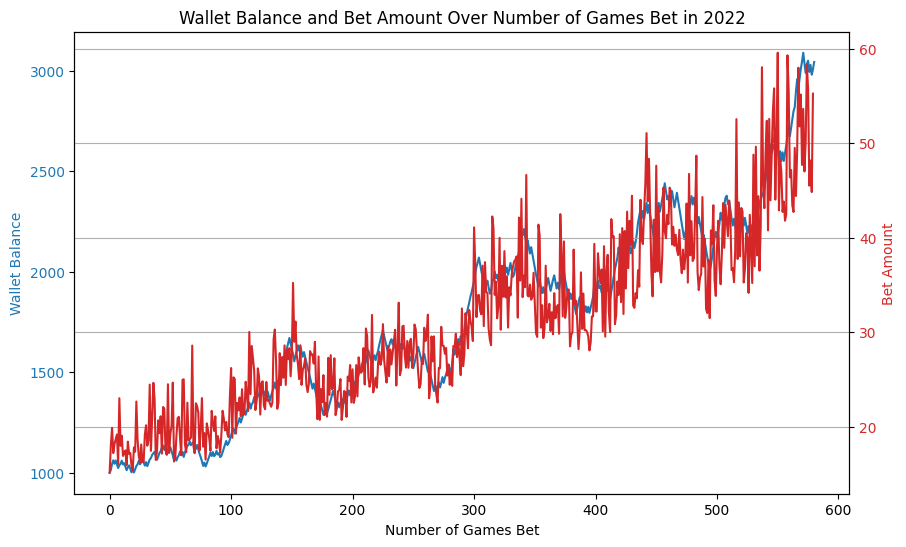

59.59789399174619
15.12258768081665
1000
3043.2687676397886


In [127]:
test_year=season_start_year
plot_wallet_balance(better, test_year)
print(max(better.bet_history))
print(min(better.bet_history))
print(min(better.wallet_history))
print(better.wallet_history[-1])


In [128]:
view_data(per_game_finished)

There are no NaN values in the dataset


In [129]:
# view_data(pitcher_names)
view_data(batter_data)



    #return missing_player_ids_train, missing_player_ids_val, missing_player_ids_test, avg_class_report, avg_conf_matrix, better.bet_history, better.wallet_history


There are no NaN values in the dataset
